In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 获取数据

In [2]:
train_dir = "./10monkeys/training/training/"
valid_dir = "./10monkeys/validation/validation/"
label_file = "./10monkeys/monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

True
True
True


In [3]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

### 1.1【重点】数据增强

In [4]:
height = 128      # 图片高度缩放
width = 128       # 图片宽度缩放
channels = 3
batch_size = 64
num_classes = 10

# 实时数据增强
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # 随机旋转图片角度，-40度至40度之间
    width_shift_range=0.2,  # 随机选择0-20%的像素进行水平平移
    height_shift_range=0.2,  # 随机选择0-20%的像素进行垂直平移
    shear_range=0.2,    # 随机剪切强度
    zoom_range=0.2,     # 随机缩放强度
    horizontal_flip=True,   # 随机做水平翻转
    fill_mode="nearest")  # 像素填充规则

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size= batch_size,
    seed=7,
    shuffle=True,
    class_mode="categorical")

valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(height, width),
    batch_size=batch_size,
    seed=7,
    shuffle=False,
    class_mode="categorical")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [6]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y[:10])

(64, 128, 128, 3) (64, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(64, 128, 128, 3) (64, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, 
                        kernel_size=3, 
                        padding="same",
                        activation="relu", 
                        input_shape=[width, height, channels]),
    keras.layers.Conv2D(filters=32, 
                        kernel_size=3, 
                        padding="same",
                        activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=64, 
                        kernel_size=3, 
                        padding="same",
                        activation="relu"),
    keras.layers.Conv2D(filters=64, 
                        kernel_size=3, 
                        padding="same",
                        activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=128, 
                        kernel_size=3, 
                        padding="same",
                        activation="relu"),
    keras.layers.Conv2D(filters=128, 
                        kernel_size=3, 
                        padding="same",
                        activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

In [8]:
epochs = 10
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_num // batch_size,
    epochs= epochs,
    validation_data=valid_generator,
    validation_steps=valid_num // batch_size)

Epoch 1/10
17/17 [==============================] - 59s 3s/step - loss: 2.3508 - accuracy: 0.1074 - val_loss: 2.2806 - val_accuracy: 0.1172
Epoch 2/10
17/17 [==============================] - 59s 3s/step - loss: 2.2903 - accuracy: 0.1268 - val_loss: 2.2451 - val_accuracy: 0.1914
Epoch 3/10
17/17 [==============================] - 56s 3s/step - loss: 2.2373 - accuracy: 0.1643 - val_loss: 2.1444 - val_accuracy: 0.1836
Epoch 4/10
17/17 [==============================] - 59s 3s/step - loss: 2.0636 - accuracy: 0.2509 - val_loss: 1.8629 - val_accuracy: 0.3750
Epoch 5/10
17/17 [==============================] - 56s 3s/step - loss: 1.9217 - accuracy: 0.3112 - val_loss: 1.7062 - val_accuracy: 0.3711
Epoch 6/10
17/17 [==============================] - 58s 3s/step - loss: 1.7462 - accuracy: 0.3752 - val_loss: 1.7022 - val_accuracy: 0.3789
Epoch 7/10
17/17 [==============================] - 61s 4s/step - loss: 1.7036 - accuracy: 0.3741 - val_loss: 1.6607 - val_accuracy: 0.4062
Epoch 8/10
17/17 [==

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

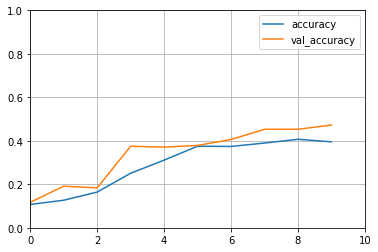

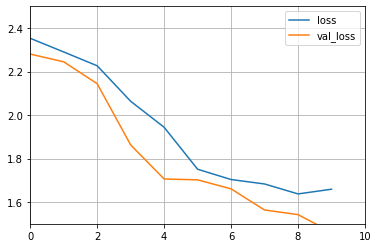

In [10]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data["val_"+label] = history.history["val_"+label]
    pd.DataFrame(data).plot(figsize=(6, 4))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, "accuracy", epochs, 0, 1)
plot_learning_curves(history, "loss", epochs, 1.5, 2.5)